In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import datetime
import io

from PIL import Image
from IPython.display import Image as IPyImage
import imageio

print("Version: ", tf.__version__)
tf.get_logger().setLevel('INFO')

Version:  2.15.0


In [ ]:
def get_model():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(1, activation='linear', input_dim=784))
  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.1), loss='mean_squared_error', metrics=['mae'])
  return model

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
class MyCustomCallback(tf.keras.callbacks.Callback):
  def on_train_batch_begin(self, batch, logs=None):
    print('Training: batch {} begins at {}'.format(batch, datetime.datetime.now().time()))

  def on_train_batch_end(self, batch, logs=None):
    print('Training: batch {} begins at {}'.format(batch, datetime.datetime.now().time()))

In [ ]:
model = get_model()
_ = model.fit(x_train, y_train,
          batch_size=64,
          epochs=1,
          steps_per_epoch=5,
          verbose=0,
          callbacks=[MyCustomCallback()])

Training: batch 0 begins at 09:25:30.114681
Training: batch 0 begins at 09:25:30.720341
Training: batch 1 begins at 09:25:30.722168
Training: batch 1 begins at 09:25:30.725841
Training: batch 2 begins at 09:25:30.726992
Training: batch 2 begins at 09:25:30.730070
Training: batch 3 begins at 09:25:30.731135
Training: batch 3 begins at 09:25:30.734412
Training: batch 4 begins at 09:25:30.734898
Training: batch 4 begins at 09:25:30.739247


### An overview of callback methods

In [ ]:
callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs:
    print("Epoch: {}, Val/Train loss ratio: {:.2f}".format(epoch, logs["val_loss"] / logs["loss"]))
)
model = get_model()
_ = model.fit(x_train, y_train,
              validation_data=(x_test, y_test),
              batch_size=64,
              epochs=3,
              verbose=0,
              callbacks=[callback])

Epoch: 0, Val/Train loss ratio: 0.13
Epoch: 1, Val/Train loss ratio: 0.61
Epoch: 2, Val/Train loss ratio: 0.29


In [ ]:
callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs:
    print("Epoch: {}, {}, {}".format(epoch, logs["val_loss"] , logs["loss"]))
)
model = get_model()
_ = model.fit(x_train, y_train,
              validation_data=(x_test, y_test),
              batch_size=64,
              epochs=3,
              verbose=1,
              )

Epoch 1/3
938/938 [==============================] - 4s 4ms/step - loss: 33.1324 - mae: 4.7408 - val_loss: 59.2224 - val_mae: 7.0842
Epoch 2/3
938/938 [==============================] - 3s 3ms/step - loss: 32.2907 - mae: 4.6697 - val_loss: 39.0763 - val_mae: 5.5991
Epoch 3/3
938/938 [==============================] - 4s 4ms/step - loss: 32.3529 - mae: 4.7446 - val_loss: 60.9648 - val_mae: 7.1386


In [ ]:
callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs:
    print("Epoch: {}, {}".format(epoch, logs))
)
model = get_model()
_ = model.fit(x_train, y_train,
              validation_data=(x_test, y_test),
              batch_size=64,
              epochs=3,
              verbose=0,
              callbacks=[callback])

Epoch: 0, {'loss': 33.01507568359375, 'mae': 4.687478542327881, 'val_loss': 5.592709541320801, 'val_mae': 1.9122246503829956}
Epoch: 1, {'loss': 32.439109802246094, 'mae': 4.738884925842285, 'val_loss': 37.58181381225586, 'val_mae': 5.514959335327148}
Epoch: 2, {'loss': 32.28522872924805, 'mae': 4.671040058135986, 'val_loss': 6.189034938812256, 'val_mae': 1.9426844120025635}


In [ ]:
class DetectiveOverfittingCallback(tf.keras.callbacks.Callback):
  def __init__(self, threshold=0.7):
    super(DetectiveOverfittingCallback, self).__init__()
    self.threshold = threshold

  def on_epoch_end(self, epoch, logs=None):
    ratio = logs["val_loss"] / logs["loss"]
    print("Epoch: {}, Val/Train loss ratio: {:.2f}".format(epoch, ratio))

    if ratio > self.threshold:
      print("Stopping training ...")
      self.model.stop_training = True

model = get_model()
_ = model.fit(x_train, y_train,
              validation_data=(x_test, y_test),
              batch_size=64,
              epochs=3,
              verbose=0,
              callbacks=[DetectiveOverfittingCallback()])

Epoch: 0, Val/Train loss ratio: 0.61
Epoch: 1, Val/Train loss ratio: 0.79
Stopping training ...


### Custom callback to Visualize predictions

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

In [ ]:
# Visualization utilities
plt.rc('font', size=20)
plt.rc('figure', figsize=(15, 3))

def display_digits(inputs, outputs, ground_truth, epoch, n=10):
    plt.clf()

    plt.yticks([])
    plt.grid(None)
    inputs = np.reshape(inputs, [n, 28, 28])
    inputs = np.swapaxes(inputs, 0, 1)
    inputs = np.reshape(inputs, [28, 28*n])
    plt.imshow(inputs)
    plt.xticks([28*x+14 for x in range(n)], outputs)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if outputs[i] == ground_truth[i]:
            t.set_color('green')
        else:
            t.set_color('red')
    plt.grid(None)

In [14]:
class VisCallback(tf.keras.callbacks.Callback):
  def __init__(self, inputs, ground_truth, display_freq=10, n_samples=10):
    self.inputs = inputs
    self.ground_truth = ground_truth
    self.images = []
    self.display_freq = display_freq
    self.n_samples = n_samples

  def on_epoch_end(self, epoch, logs=None):
    indexes = np.random.choice(len(self.inputs), size=self.n_samples)
    X_test, y_test = self.inputs[indexes], self.ground_truth[indexes]
    predictions = np.argmax(self.model.predict(X_test), axis=1)
    display_digits(X_test, predictions, y_test, epoch, n=self.n_samples)
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    image = Image.open(buf)
    self.images.append(np.array(image))

    if epoch % self.display_freq == 0:
      plt.show()
  def on_train_end(self, logs=None):
    imageio.mimsave(GIF_PATH, self.images, fps=1)

In [15]:
def get_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation='linear', input_dim=784))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [18]:
GIF_PATH = './animation.gif'

1/1 [==============================] - 0s 63ms/step


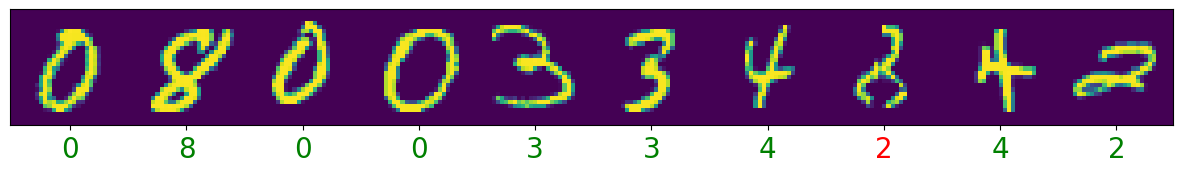

1/1 [==============================] - 0s 20ms/step


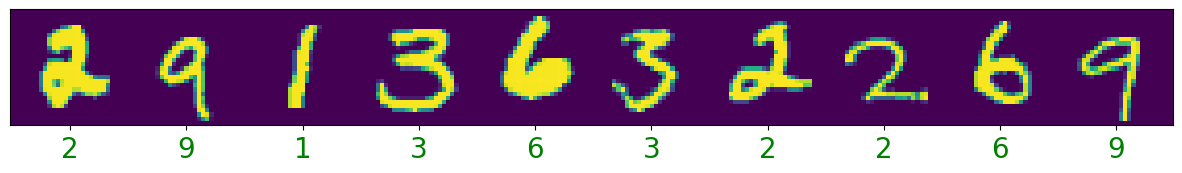

1/1 [==============================] - 0s 20ms/step


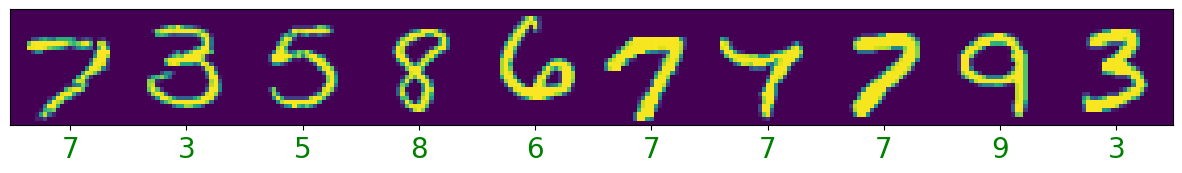

In [19]:
model = get_model()
model.fit(x_train, y_train,
          batch_size=64,
          epochs=20,
          verbose=0,
          callbacks=[VisCallback(x_test, y_test)])

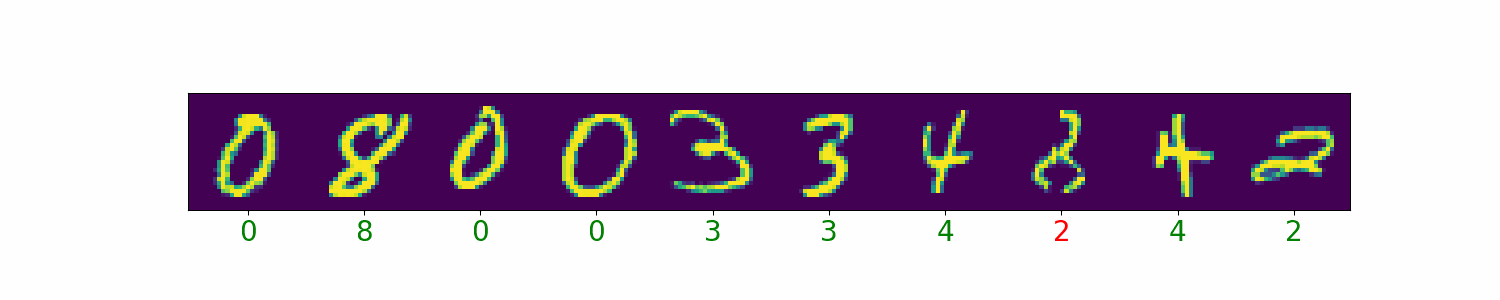

In [20]:
SCALE = 60

# FYI, the format is set to PNG here to bypass checks for acceptable embeddings
IPyImage(GIF_PATH, format='png', width=15 * SCALE, height=3 * SCALE)